# SMAI Assignment 1: Decision Tree

Snehashis Pal <br>
M.Tech Sem II(CSE) <br>
Roll no : 2018201072



## 1. Python modules used
<ol>
    <li>Numpy for storing and manipulating data.</li>
    <li>Pandas for reading csv data and organizing into numpy arrays</li>
    <li>Scikit learn for comparison with its version of decision tree</li>
    <li>Matplotlib for creating graphs</li>
</ol>

In [139]:
import numpy as np
import pandas as pd
from sklearn import tree as dtree
from sklearn import preprocessing
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numbers


## 2. Code Structure 

The code for the decision tree is written as a set of functions which forms 
the core part of the decision trees. 
It includes the set of functions and parameters which are then called to do the 5 different questions. 
The following sections details the working of the core functions of the code

## 3. Core Functions

The core functions is a set of functions for creating the decision tree based on some impurity metric function. This inolves 
<ul>
    <li>Loading the data</li>
    <li>Separting the various attributes into either numerical or categorical</li>
    <li>Finding a way of spliting data into subsets based on maximum information gain</li>
    <li>Separating the dataset into train and validation sets</li>
    <li>Creating a decision tree based on the training data greedily using the impurity metric used</li>
    <li>Predicting the label of an unknown data using the created tree</li>
</ul>

### 3.1 Impuriy functions 
Three different impurity metrics are used 
<ol>
    <li>Entropy : $E(t) = -1 * (t * log_2(t) + (1 - t) * log_2(1-t)$)</li>
    <li>Gini Index :  $G(t) = 2t(t - 1)$</li>
    <li>Misclassification : $M(t) = min(t,1-t)$</li>
</ol>
where $t$ is the ratio of positive or negative label values to the total number of data in the set. 
<br>For explainations we mostly refer to the impurity function as the entropy function although any one of the three can be used intechangebly as long as the one chosen is used consistantly throughout the program.

In [140]:

#define entropy function
def entropy(q):
    #print(q)
    if q <= 0 or q >= 1:
        return 0
    return -1 * (q * np.log2(q) + (1- q) * np.log2(1-q))
#define gini index
def gini_index(q):
    if q <= 0 or q >= 1:
        return 0
    return 2 * q * (1 - q)
#define misclassification rate
def miss_rate(q):
    if q <= 0 or q >= 1:
        return 0
    return min(q,1 - q)
#define function to determin which type was used
def ftype(func):
    if func == entropy:
        return "entropy"
    else:
        return "gini"


### 3.2 Getting the information gain ratio 

<b>Categorcal Data</b>
<p>If the attribute is a categorical one we need to find the information gained by splitting the set of tuples into subsets based on the value of the attribute. The information gained is the difference in the current entropy and the weighted sum of the resulting entropy of the subsets based on the label value. Here entropy is a measure of the randomness of a system and may be calculated as any one of the three impurity fuctions provided. The information gain is then divided with the intrinsic information of the split to prevent overfitting.</p> 
<p>The overall procedure is 
    <ol>
        <li>Calculate Current Entropy $CE(S = Current Set) = E(\dfrac{p}{|S|})$ where p is the number of positive values(1) in set $S$</li>
        <li>For every value unique of an attribute $A$ in the given dataset if $S_i$ is the number of elements in the subset of $S$ which has the value of $A_i$ the calculate $E(A_i) = E(\dfrac{p_i}{|S_i|})$</li>
        <li>Calculate weighted entropy of the division as $E(A) = \sum_{A_i \in A}\dfrac{|S_i|}{|S|}E(A_i)$</li>
        <li>Calculate intrinsic information $I(A) = -1 * \sum_{S_i \in S}\dfrac{|S_i|}{|S|}log_2(\dfrac{|S_i|}{|S|})$</li>
        <li>The gain ratio is calculated as $\dfrac{CE(S) - E(A)}{I(A)}$
     

In [141]:
#calculate gain ratio of a categorical data
def cat_gain_ratio(data_label,func):
    
    attr_cat = np.unique(data_label[:,0],return_counts = True)
    if attr_cat[0].shape[0] == 1:
        return (-1,-1)
    attr_countn = data_label.shape[0]
    prev_res = func(np.sum(data_label[:,1])/attr_countn)
    if prev_res == 0:
        return (-1,-1)
    
    intr = 0
    weight_entropy = 0
    
    for attr,attr_count in list(zip(attr_cat[0],attr_cat[1])):
        intr += (attr_count/attr_countn) * np.log2(attr_count/attr_countn)
        q = np.sum((data_label[:,0] == attr) & (data_label[:,1] == 1)) / attr_count
        weight_entropy += (attr_count/attr_countn) * func(q)
    
    intr = -1 * intr
    if intr:
        # the result is returne as a tuple to conform it to the same return mechanism as the next function
        # which is used to calculate the gain ratio of numerical attributes
        return ((prev_res - weight_entropy)/intr,0)
    return (0.0,0)
    

#### Numerical Data 

For attributes which take values from a continous range, we need to split the set of data into subsets, similar to what we did for categorical types, such that the resulting set of subsets gives us a maximum information gain ratio. We can intuitively think of a numerical attribute in a dataset as a large set of discrete values. We can split the set on all such distinct values of the numerical attribute but this will lead to a lot of overfitting as some partitions are left with very minimal values to base decisions on. This is also computationally more expensive. We should only split when there is an information gain in doing so. We also need to make sure that how we split the dataset can be easily calclated during prediction so that the prediction algorithm can determine which branch to take efficiently. Thus, we always split the set into two parts based on the numerical attribute, such that the resulting information gain from the split is maximum. The first part consists of all those values which are lower than a given value $s \in A$ where $A$ is numerical attribute on which we have to find a split and $s$ the value at which the split will take place. The algorithm for the procedure is. 

<ol>
    <li>Calulate current entropy (same as categorical). Count the number of 1's(or 0's) in the set as $c$.
    <li>Sort the dataset $D$ on the attribute $A$</li>
    <li>Scan $D$ rowise using a index $i$ keeping track of the number or 1's(or 0's) as $p$.</li>
    <li>If $D[i,A]$ (value of the attribute A for the ith row) $\ne$ $D[i-1,A]$ then we can split the dataset into two parts namely $D_{<=s_i}$ and $D_{>s_i}$ with $s_i = D[i,A]$.</li>
    <li>Calulate information gain as $G(s_i) = CE(S) - (\dfrac{i}{|S|}E(\dfrac{p}{i}) + \dfrac{|S|-i}{|S|}E(\dfrac{c - p}{|S|-i}))$</li>
            <li>Similarly calculate the intrinsic information as $I(s_i) = -1 * (\dfrac{i}{|S|}log_2(\dfrac{i}{|S|}) + \dfrac{|S|-i}{|S|}log_2(\dfrac{|S|-i}{|S|}))$</li>
    <li>Get $\max_{\forall s_i}(\dfrac{G(s_i)}{I(s_i)})$ i.e. for every split possible calculate the gain ratio and select the split which gives the maximum. Select the $s_i$ as the split point for the attribute.

In [142]:
#calculate gain ratio with numerical data
def num_gain_split(data_label,func):
    
    attr_countn = data_label.shape[0]
    left_countn = np.sum(data_label[:,1] == 1)
    prev_res = func(left_countn/attr_countn)
    if prev_res == 0:
        return -1,-1
    
    data_label = sorted(data_label,key = lambda x:x[0])
    csum = data_label[0][1]
    pos = 0
    max_ratio = 0
    split_pos = 0
    
    for i in data_label[1:attr_countn-1]:
        if i[0] == data_label[pos][0]:
            csum += i[1]
            pos += 1
            continue
        intr = -1 * (((pos + 1)/attr_countn) * np.log2((pos + 1)/attr_countn) + \
                ((attr_countn - pos - 1)/attr_countn) * np.log2((attr_countn - pos - 1)/attr_countn))
        q = (prev_res - (((pos + 1)/attr_countn) * func(csum/(pos + 1)) + \
                ((attr_countn - pos - 1)/attr_countn) * \
                func((left_countn - csum)/(attr_countn - pos - 1))) \
                )/intr
        if q > max_ratio:
                max_ratio = q
                split_pos = pos
        csum += i[1]
        pos += 1

    return (max_ratio,data_label[split_pos][0])
        
    

Once we find the attribute to split on we divide the set into subsets of data based on the value of the attribute

In [143]:
#this function splits a numerical or categorical attribute 
#for categorical data it splits it into subsets with each subset representing a unique value 
#for numerical data it splits it into two parts one ' <= Split point ' and the other ' > Split Point'
def split_attribute(data,attr_type = 1,sp = 0):
        
    if attr_type:
        #split on categorical attribute
        attr_cat = np.unique(data)
        attr_pos = []
        for attr in attr_cat:
            attr_pos += [(attr,np.where(data == attr))]

        return attr_pos
    else:
        #split on numerical attribute
        return [(sp,np.where(data <= sp)),(sp+1,np.where(data > sp))]

### 3.3 Creating Decision Tree

A decision tree is created based on the information function. The steps are 
<ol>
    <li>Calulate and store the number of 1's and 0's in the current set for prediction of test data</li>
    <li>Find the the attribute which results in the maximum gain ratio. Use the two different process for categorical and numerical data as discussed before.</li>
    <li>Split the data set based on the unique values of chosen attribute into subsets.</li>
    <li>For each subset perform the operations 1 and 2 (recurse) untill we get a subset where the information gain ratio evaluates to zero. The information gain evaluates to zero if either
        <ul>
            <li>When all attributes have the save values in the subset. Thus no attribute can be branched any further.</li> 
            <li>When all labels in the curent subset is of a single type making any further divisions pointless.</li>
        </ul>
    In both cases information gain evaluates to zero.
    </li>
</ol>

In python the tree nodes are represented as a 4-tuple with the format ```(attribute_name, count of 1, count of 0, {dict of nodes})```. A dictionary with key as unique attribute values for categorical, and split point,(split point + 1) for numerical is used. Example on the attribute ```sales``` the structure of the node will be ```('sales',1's in set,0's in set,{'low':(subset induced by sales = low), 'high':(subset induced by sales = high, 'medium':(subset induced by sales = medium)})```. Leaf nodes in the tree are do not have dictionaries for branches and the attribute parameter is replaced with -1. eg ```(-1,count of 1,count of 0)```


In [144]:
#create the tree 
def create_tree(dataset,attr_type,label,func):
    
    i = 0
    max_ent = 0
    res = []
    #find the max gain stored in a result vector while creating it 
    while i < len(attr_type):
        if i == label:
            res += [(-1,-1)]
        elif attr_type[i]:
            res += [cat_gain_ratio(dataset[:,[i,label]],func)]
        else:
            res += [num_gain_split(dataset[:,[i,label]],func)]
        if res[i][0] > res[max_ent][0]:
            max_ent = i
        i += 1
    
    #store count of 1 and 0
    onec = np.sum(dataset[:,label])
    zeroc = dataset.shape[0] - onec
    #return a leaf node with count of 1's and 0's in current subset if max gain is zero 
    if res[max_ent][0] <= 0.0:
        return (-1,onec,zeroc)
    branch = {}
    #otherwise create a dictionary of child nodes to return
    split_vec = split_attribute(dataset[:,max_ent],attr_type[max_ent],res[max_ent][1])
    for attr,arr in split_vec:
        branch[attr] = create_tree(dataset[arr],attr_type,label,func)
    return (max_ent,onec,zeroc,branch)
    

### 3.4 Prediction Algorithm (Part - 6)

This part also has the answer to part 6 of the assignment.
To predict the label of a data we need to find the most appropriate class to which it belongs using the decision tree. At every level we take the branch in the tree using the value of the attribute in the test data on which the current node branches. This continues untill we reach a leaf node and return the number of 1's and 0's in that node. The predictor simply takes the highier of the two values as the output. 

There may be two problems that arise in the process. 
<ul>
    <b><li>Missing branch problem</li></b>
    There may not be a branch corresponding to the value of the attribute present in the test data. This situation may arise when a partition on the initial set induced subsets which do not have all possible values for an attribute in the resulting subsets. As such the prediction algorithm may reach a point in the tree which does not have data for a pirticular value of an attribute. All training data with the required attribute value has been eliminated from the current subset in the tree by the previous attributes using which it as partitioned. Thus at this point the decision tree has no way of determinig which path to take. The data with the given attribute combinations has not been encountered in its training set.
    <br><br>
    <b><li>Missing/New attribute value problem</li></b>
    This problem occurs when the test data contains a missing or newly encountered attribute which was previously not present in the tree. In this case, similar to the previous situation the decision tree cannot determine the branch to take as such a data has not been encountered before.
</ul>
    
To handle these two situation we may take two different approaches.
<ul>
    <b><li>Predict using the label(0 or 1) counts at the current level</li></b>
    In this approach we return the greater of the count of the two labels on finding a missing branch/attribute value. This approach is straightforward and easy to compute but has a drawback. It disregards any attribute or numerical splits that has not been encountered in the path from the root of the tree i.e. some of the information present in the test data is not utilized to predict its label.
    <b><li>Predicting the label taking all branches possible</li></b>
    We are underutilizing the information present in the test data in the first solution. As the remaining attributes which have not been inspected may be present in the lower levels of the trees we check all such branches, and sum the count of labels from all subtrees which have attributes values equal to the values of the remaining attributes only. This way we are using the data given to us to segregate out irrelevant data to make a better prediction on the test data. The disadvantage to this process is that its computationally expensive for data with many missing attributes as multiple branches need to be evaluated to get all relevant data based on other attributes.
</ul>
    

In [145]:

#prediction algorithm
#max_rec parameter is used to limit the depth upto which prediction will recurse into 
#used for question no 5
def predict(testdata,attr_type,dec_tree,max_rec = 2000000):
    
    #return counts of 1's and 0's if leaf or we have reached max depth
    if max_rec  == 0 or dec_tree[0] == -1:
        return [dec_tree[1],dec_tree[2]]
    #for categorical inputs
    elif attr_type[dec_tree[0]]:
        #if test attribute value is present in the branches of the current node
        if testdata[dec_tree[0]] in dec_tree[3].keys():
            return predict(testdata,attr_type,dec_tree[3][testdata[dec_tree[0]]],max_rec-1)
        #otherwise calulate sum by recursing to all 
        count = np.array([0,0])
        for val in dec_tree[3].values():
            count += np.array(predict(testdata,attr_type,val,max_rec-1))
        return [count[0],count[1]]
    else:
        sp = sorted(list(dec_tree[3].keys()))
        #for numerical data which have numerical values take the branch based on the value
        if isinstance(testdata[dec_tree[0]],numbers.Number):
            if testdata[dec_tree[0]] <= sp[0]:
                return predict(testdata,attr_type,dec_tree[3][sp[0]],max_rec-1)
            else:
                return predict(testdata,attr_type,dec_tree[3][sp[1]],max_rec-1)
        #otherwise take both branches and calcualte sum
        else:
            c = np.array(predict(testdata,attr_type,dec_tree[3][sp[0]],max_rec-1)) + \
                np.array(predict(testdata,attr_type,dec_tree[3][sp[1]],max_rec-1))
            return [c[0],c[1]]

### 3.5 Training and Testing

The given dataset is divided into training set and validation set. The training set is then used to create the decision tree. The validation dataset is used to perform analysis on the system based on four attributes namely,
Accuracy, Precision, Recall and F1 score. The test set is obrained from a separate csv file with all attributes present except the prediction label. The test set may be ommited and the system will then only do validation testing on split data.

In [146]:
#test data and show stats
#takes a decision tree, test/validation set of data, prediction label index,type of attributes and returns
#its accuracy, precision, reacall, F1 score
#max_rec is used to calculate prediction only goi
def testtree(tree,test,label,attr_type,showstats=1,max_rec = 2000000):
    if test.shape[0] == 0:
        print("No validation data remaining")
        return 
    
    tp,tn = 0,0
    fp,fn = 0,0

    for d in test:
        p = predict(d,attr_type,tree,max_rec)
        p = p[0] > p[1]
        if int(p) == int(d[label]):
            if int(p) == 1:
                tp += 1
            else:
                tn += 1
        else:
            if int(p)== 1:
                fp += 1
            else:
                fn += 1
                
    acc = ((tp + tn)/test.shape[0])*100
    rec = tp/(tp + fn)
    pre = tp/(tp + fp)
    f1s = 2/(1/rec + 1/pre)
    
    if showstats:
        print("My Implementation \n==================================")
        print("Validation data prediction:")
        print("Total dataset size",test.shape[0])
        print("True positive",tp,"True Negetive",tn,"Correct Predictions",tn + tp)
        print("False positive",fp,"False Negetive",fn,"Incorrect Predictions",fn + fp)
        print("Accuracy:",acc,"% | Recall:",rec,"| Precision:",pre,"| F1 score:",f1s)
        print("-------------------------------")
    return (acc,rec,pre,f1s)

We then compare our results with the scikit learns implementation using the same training and validation set.

In [147]:
#scikit - learn implementation
def sklearn_dec(data,tlim,label,test):
    i = 0
    tdata = np.zeros([data.shape[0],1])
    if test is not None:
        pdata = np.zeros([test.shape[0],1])
    le = preprocessing.LabelEncoder()
    while i < data.shape[1]:
        if i != label:
            if attr_type[i]:
                le.fit(np.unique(data[:,i]))
                tdata = np.hstack((tdata,le.transform(data[:,i]).reshape(-1,1)))
                if test is not None:
                    pdata = np.hstack((pdata,le.transform(test[:,i]).reshape(-1,1)))
            else:
                tdata = np.hstack((tdata,data[:,i].reshape(-1,1)))
                if test is not None:
                    pdata = np.hstack((pdata,test[:,i].reshape(-1,1)))
        i += 1
    
    tdata = np.delete(tdata,0,1)
    if test is not None:
        pdata = np.delete(pdata,0,1)
    traindata = tdata[:tlim]
    valdata = tdata[tlim:]
    trainlabel = data[:tlim,label].astype(int)
    validationlabel = data[tlim:,label]
    clf = dtree.DecisionTreeClassifier(criterion=ftype(imp_measure))
    clf.fit(traindata,trainlabel)
    
    if valdata.shape[0] != 0:
        tp,tn = 0,0
        fp,fn = 0,0
        for i,j in list(zip(valdata,validationlabel)):
            p = int(clf.predict([i])[0])
            if p == int(j):
                if p == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                if p == 1:
                    fp += 1
                else:
                    fn += 1
    
        print("Validation data prediction:")
        print("Total dataset size",valdata.shape[0])
        print("True positive",tp,"True Negetive",tn,"Correct Predictions",tn + tp)
        print("False positive",fp,"False Negetive",fn,"Incorrect Predictions",fn + fp)
        acc = ((tp + tn)/valdata.shape[0])*100
        rec = tp/(tp + fn)
        pre = tp/(tp + fp)
        f1s = 2/(1/rec + 1/pre)
        print("Accuracy:",acc,"% | Recall:",rec,"| Precision:",pre,"| F1 score:",f1s)
        print("-------------------------------")
    else:
        print("No validation data remaining")
    
    if test is not None:
        print("Test data predictions:")
        for i,j in list(zip(test,pdata)):
            print(i,"result =",int(clf.predict([j])[0]))
            
    

#### Testing Parameters

The following section of code gives the set of parameters used for loading and handeling ddata of different type.
The user has to provide information on the type of attributes, categorical or numerical. This is done through the use of a $d$ dimensional boolean vector where $d$ is the dimension of the data i.e. the number of attributes. 
The user also provides a data splitting factor between $(0-1)$ which determines the percentage of the entire data used for training(creating decision tree) and validating on that data. The user also provides name of the attribute to be regarded as the label (binary 0 or 1) in the given dataset. The following are the set of parameters with the default parameters set to work on the dataset provided.

In [148]:
#parameters for the questions

#data location 
data_loc = 'decision_Tree/train.csv'

#split percentage of training set
#by default the program uses the remaining data for validation
split = 0.9

#attribute type : 1 for categorical data, 0 for numerical data 
#represented as a boolean vector of same dimensions as the data including label attribute
attr_type = [0,0,0,0,0,1,1,1,1,1]
''' 
     example for the given data
     0 : 'satisfaction_level', 
     1 : 'last_evaluation', 
     2 : 'number_project', 
     3 : 'average_montly_hours', 
     4 : 'time_spend_company', 
     5 : 'Work_accident',
     6 : 'left', 
     7 : 'promotion_last_5years', 
     8 : 'sales', 
     9 : 'salary'
    
     for satisfacation level to be treated as categorical set attr_type[0] = 1
     similarly set attr_type[9] = 1 for salary to be considered categorical
     otherwise set attr_type[0] = 0 for it to be a numerical data
'''

#attribute name on which the classification will take place 
attr_name = "left"

#test data location, will not be evaluated if left as None 
#test data is assumed to have all attributes as there are in training data except the classification attribute
test_data_loc = "decision_Tree/sample_test.csv"

#default impurity measure func
imp_measure = entropy

#function to set parameters, with default params
def setParams(dl=data_loc,sp = split,atp = attr_type,anm = attr_name,ipm = imp_measure,tdl = test_data_loc):
    global data_loc,split,attr_name,attr_type,test_data_loc,imp_measure
    data_loc = dl
    split = sp
    attr_type = atp
    attr_name = anm
    imp_measure = ipm
    test_data_loc = tdl

The parameters are by default given to be used on the train.csv dataset with the sample_test.csv as the test set.
The user may modify the parameters coded above in the notebook file or run the following code with the function call, uncommented to get the data interactively from the user.

In [155]:
def getParamsUser():
    global data_loc,split,attr_name,attr_type,test_data_loc,imp_measure    
    data_loc = str(input("Enter the location of trainiing/validation data "))
    data = pd.read_csv(data_loc)
    print("Assigned indexes to the columsn")
    i = 0
    for head in data.columns.values:
        print(head,"= Index",i)
        i += 1
    split = float(input("Enter the train - validation split percentage (0-1) "))
    attr_name = str(input("Enter the label attribute "))
    test_data_loc = str(input("Enter the test data location (optional) "))
    if test_data_loc == "":
        test_data_loc = None
        print("No test data given")
    print("Enter the type of each attribute (0 - numerical, 1 categorical)")
    attr_type = []
    for head in data.columns.values:
        if head == attr_name:
            attr_type += [1]
        else:
            attr_type += [int(input(head + str(" type? ")))]
    print("Parameters has been set")
            
#uncomment to get data manualy            
#getParamsUser()

A utility function that loads the data into a dataframe, splits it into training and validation data, creates the tree, performes validation testing, shows results and compares with scikit learns implementation(if set to do so) and predicts the test data. The parameters must be set correctly for this functino to work.

In [153]:
#utility function
#shows stats if showstats is true (default)
#comparing with scikit learns implementation if schk is true
#max recursion or the depth to which a prediction will traverse the tree
#optional parameter for a previously computed tree
def runDecisionTree(showstats=1,schk=1,max_rec=2000000,tree=None):
    pdata = pd.read_csv(data_loc)
    pdata = pdata.sample(frac=1)
    data = pdata.values
    label = pdata.columns.get_loc(attr_name)
    
    tlim = int(split*data.shape[0])
    train = data[:tlim]
    vdata = data[tlim:]
    if tree is None:
        tree = create_tree(train,attr_type,label,imp_measure)
    
    ret = testtree(tree,vdata,label,attr_type,showstats,max_rec)

    if schk:
        tdata = None
        if test_data_loc is not None:
            ptdata = pd.read_csv(test_data_loc)
            ptdata[attr_name] = np.zeros([ptdata.shape[0],1])
            tdata = ptdata[pdata.columns.values].values
            print("Test data predictions:")
            for i,j in list(zip(tdata,ptdata.values)):
                p = predict(i,attr_type,tree)
                print(j, " result =",int(p[0] > p[1]))

        print("-------------------------------")
        print("Scikit learn \n==================================")
        sklearn_dec(data,tlim,label,tdata)
    return ret,tree

## 4 Results


### 4.1 Part - 1 Categorical data

In this part we are tasked to build a decision tree with only categorical attributes. We shall consider all attributes in the data to be categorical attributes. This will lead to a large number of branches for numerical attributes. As a result the accuracy suffers due to overfitting of data. 

In [157]:
#set up the parameters for our implementation
prev_attr_type = attr_type
#in this configuration all the attributes are considered
attr_type = [1]*pd.read_csv(data_loc).shape[1]
print("Part 1 \n******************************************************\n")
res = runDecisionTree()
attr_type = prev_attr_type


Part 1 
******************************************************

My Implementation 
Validation data prediction:
Total dataset size 2248
True positive 514 True Negetive 1652 Correct Predictions 2166
False positive 57 False Negetive 25 Incorrect Predictions 82
Accuracy: 96.35231316725978 % | Recall: 0.9536178107606679 | Precision: 0.9001751313485113 | F1 score: 0.926126126126126
-------------------------------
Test data predictions:
[0.69 0.69 3 236 4 0 0 'product_mng' 'medium' 0.0]  result = 1
[0.36 0.54 2 153 3 1 0 'accounting' 'medium' 0.0]  result = 0
-------------------------------
Scikit learn 
Validation data prediction:
Total dataset size 2248
True positive 520 True Negetive 1672 Correct Predictions 2192
False positive 37 False Negetive 19 Incorrect Predictions 56
Accuracy: 97.50889679715303 % | Recall: 0.9647495361781077 | Precision: 0.933572710951526 | F1 score: 0.9489051094890513
-------------------------------
Test data predictions:
[0.69 0.69 3 236 4 0 0.0 0 'product_mng' 'me

### Part - 2 Categorical and Numerical data

In this part a dicision tree is created with both numerical and categorical data as given by the user.

In [159]:
#parameters, first 5 attributes are numerical remaining are categorical
#although it is necessary to include the label vector in attribute type the processing is independent of the vector
#and consequently its index value in attr_type is inconsqeuntial
print("Part 2 \n******************************************************\n")
res = runDecisionTree()
#print(res[1])

Part 2 
******************************************************

My Implementation 
Validation data prediction:
Total dataset size 2248
True positive 523 True Negetive 1669 Correct Predictions 2192
False positive 35 False Negetive 21 Incorrect Predictions 56
Accuracy: 97.50889679715303 % | Recall: 0.9613970588235294 | Precision: 0.9372759856630825 | F1 score: 0.9491833030852995
-------------------------------
Test data predictions:
[0.69 0.69 3 236 4 0 0 'product_mng' 'medium' 0.0]  result = 0
[0.36 0.54 2 153 3 1 0 'accounting' 'medium' 0.0]  result = 1
-------------------------------
Scikit learn 
Validation data prediction:
Total dataset size 2248
True positive 524 True Negetive 1670 Correct Predictions 2194
False positive 34 False Negetive 20 Incorrect Predictions 54
Accuracy: 97.59786476868328 % | Recall: 0.9632352941176471 | Precision: 0.9390681003584229 | F1 score: 0.9509981851179674
-------------------------------
Test data predictions:
[0.69 0.69 3 236 4 0 0.0 0 'product_mng' '

### Part - 3 Different Impurity functions

We use three different impurity metric and compare their effectiveness. We also compare them with scikit learns implementation on entropy and gini index. 

In [162]:
#train and test with entropy
print("Part 3 \n******************************************************\n")
print("Using Entropy\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
imp_measure = entropy
res = runDecisionTree()
#train and test using gini
print("\nUsing Gini Index\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
imp_measure = gini_index
res = runDecisionTree()
#train and test using miss-classification rate 
#scikit learn does not have miss-classification rate and hence is skipped
print("\nUsing Miss classification rate\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
imp_measure = miss_rate
res = runDecisionTree(schk=0)

Part 3 
******************************************************

Using Entropy
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
My Implementation 
Validation data prediction:
Total dataset size 2248
True positive 500 True Negetive 1696 Correct Predictions 2196
False positive 25 False Negetive 27 Incorrect Predictions 52
Accuracy: 97.68683274021353 % | Recall: 0.9487666034155597 | Precision: 0.9523809523809523 | F1 score: 0.9505703422053231
-------------------------------
Test data predictions:
[0.69 0.69 3 236 4 0 0 'product_mng' 'medium' 0.0]  result = 0
[0.36 0.54 2 153 3 1 0 'accounting' 'medium' 0.0]  result = 1
-------------------------------
Scikit learn 
Validation data prediction:
Total dataset size 2248
True positive 501 True Negetive 1686 Correct Predictions 2187
False positive 35 False Negetive 26 Incorrect Predictions 61
Accuracy: 97.2864768683274 % | Recall: 0.9506641366223909 | Precision: 0.9347014925373134 | F1 score: 0.942615239887112
-----------------------

### Part - 4 Estimating decision boundaries through graphs

It is often difficult to look at a dataset with multiple attributes and uderstand at which class a pirticular set of values of attributes fall into. In short the decision boundary for a set of data can be hard to estimate. Graphical representation of data helps to visualize data and help us understand what the likely decision boundary is for a set of data point falling into one class or another. The type of decision boundary helps us to select what kind of machine learning model will best suit the data given to us. It can also serve as a tool to verify the decisions taken by such model. Graphs are plotted in 2D with one set of attributes in x direction, another in y direction and the label of the corresponding point represented as different colours. 

The set of attributes are  ['satisfaction_level' 'last_evaluation' 'number_project'
 'average_montly_hours' 'time_spend_company' 'Work_accident' 'left'
 'promotion_last_5years' 'sales' 'salary']
Enter the attribute to plot on x axis satisfaction_level
Enter the attribute to plot on y axis last_evaluation


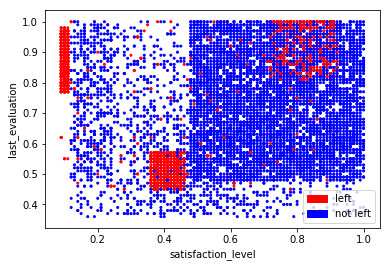

In [164]:
#function to plot graph
def print_graph(data,attr1,attr2):
    col = []
    for i in data[attr_name]:
        if i == 1:
            col += ['#ff0000'] #red color for left entries
        else:
            col += ['#0000ff'] #blue color for non-left entries 

    plt.scatter(data[attr1],data[attr2],c=col,s=4)
    plt.xlabel(attr1)
    plt.ylabel(attr2)
    red_patch = mpatches.Patch(color = 'red', label='left')
    blue_patch = mpatches.Patch(color = 'blue', label='not left')
    plt.legend(handles=[red_patch,blue_patch])
    plt.show()

pdata = pd.read_csv(data_loc)
'''
#Code to show all possible graph combinations
for i in pdata.columns.values:
    for j in pdata.columns.values:
        if i != j and i != attr_name and j != attr_name and pdata.columns.get_loc(i) < pdata.columns.get_loc(j):
            print_graph(pdata,i,j)
'''
print("The set of attributes are ",pdata.columns.values)
attr1 = input("Enter the attribute to plot on x axis ")
attr2 = input("Enter the attribute to plot on y axis ")
print_graph(pdata,attr1,attr2)

For example from the graph we can expect a decision boundary at satisfation_level = 0.11 and at 0.46. 

### Part - 5 Comparing performance of trees

Training and validation errors are calculated with increasing tree depth. Intersentingly we see a slight increase in the error rate as we make predictions using trees with more depth. This can be an indication of overfitting of data as the leaf nodes don't result in accurate results, having few samples to base their decision on. 

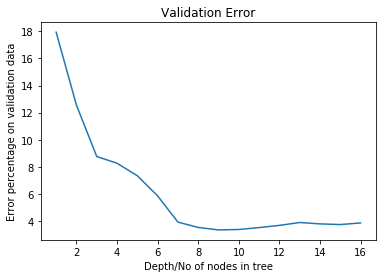

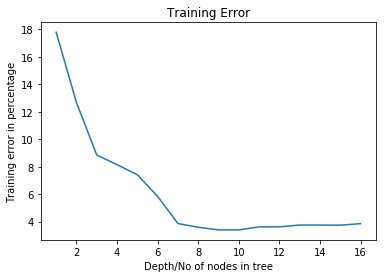

In [195]:
#set parameters for training on a numerical + categorical data
rec_max = 16
x = [x for x in range(1,rec_max+1)]
res = runDecisionTree(showstats=0,schk=0,max_rec=1)
y = [res[0]]
for i in x[1:]:
    y += [runDecisionTree(showstats=0,schk=0,max_rec=i,tree=res[1])[0]]
y = np.array(y)

#plt.subplot(2,2,1)
plt.subplots_adjust(wspace=0.5,hspace=1)
ye = np.ones([1,rec_max])*100 - y[:,0]
plt.plot(x,ye.reshape(-1,1))
plt.title("Validation Error")
plt.xlabel("Depth")
plt.ylabel("Error percentage on validation data")
plt.show()

ndata = pd.read_csv(data_loc)
lbl = ndata.columns.get_loc(attr_name)
ndata = ndata.values
trdata = ndata[int(split*ndata.shape[0]):]
t = []
for i in x:
    t += [testtree(res[1],trdata,lbl,attr_type,showstats=0,max_rec=i)[0]]
t = np.array(t)
t = np.ones([1,rec_max])*100 - t

plt.plot(x,t.reshape(-1,1))
plt.title("Training Error")
plt.xlabel("Depth")
plt.ylabel("Training error in percentage")
plt.show()



To get an idea of the percentage of error with varying no of nodes in graph we vary the amout of training data from 1% of the dataset to 99% of the dataset. This will give us trees of varying nodes as the trees with lower data result in pure states or indivisible states faster than trees holding larger dataset.

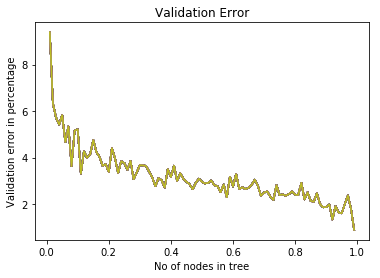

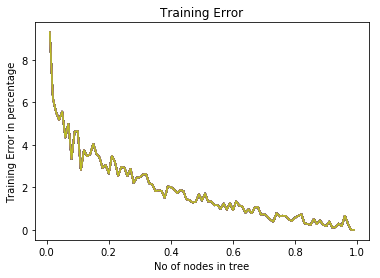

In [204]:
prev_split = split
split = 1/100
ndata = pd.read_csv(data_loc)
lbl = ndata.columns.get_loc(attr_name)
ndata = ndata.values

x = []
y = []
t = []
for i in range(1,100):
    x += [i/100]
    split = i/100
    res = (runDecisionTree(showstats=0,schk=0))
    t += [testtree(res[1],ndata[int(split*ndata.shape[0]):],lbl,attr_type,showstats=0)[0]]
    y += [res[0][0]]

y = np.ones([1,len(x)])*100 - np.array(y).reshape(-1,1)
t = np.ones([1,len(x)])*100 - np.array(t).reshape(-1,1)
plt.plot(x,y)
plt.title("Validation Error")
plt.xlabel("No of nodes in tree")
plt.ylabel("Validation error in percentage")
plt.show()

plt.plot(x,t)
plt.title("Training Error")
plt.xlabel("No of nodes in tree")
plt.ylabel("Training Error in percentage")
plt.show()
split = prev_split